In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_csv('gold-dataset-sinha-khandait.csv', parse_dates = ['Dates'])

C:\Users\flel8\AppData\Local\Temp\ipykernel_30240\1764994241.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('gold-dataset-sinha-khandait.csv', parse_dates = ['Dates'])


In [4]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

# Data Inspection

In [6]:
df.head()

,dates,url,news,price_direction_up,price_direction_constant,price_direction_down,asset_comparision,past_information,future_information,price_sentiment
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",0,0,1,0,1,0,negative
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,0,0,1,0,1,0,negative
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,0,0,0,1,0,positive
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...,0,0,0,0,0,1,none
4,06-09-2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",0,0,1,0,1,0,negative


In [7]:
summary = df.describe()
nunique_df = pd.DataFrame(df.nunique(), columns=['nunique']).T
df_summary = pd.concat([summary, nunique_df])
df_summary

,price_direction_up,price_direction_constant,price_direction_down,asset_comparision,past_information,future_information,dates,url,news,price_sentiment
count,10570.000000,10570.000000,10570.000000,10570.000000,10570.000000,10570.00000,NaN,NaN,NaN,NaN
mean,0.417408,0.042006,0.370104,0.189309,0.969915,0.03018,NaN,NaN,NaN,NaN
std,0.493155,0.200612,0.482855,0.391773,0.170830,0.17109,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,NaN,NaN,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,NaN,NaN,NaN,NaN
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,NaN,NaN,NaN,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,NaN,NaN,NaN,NaN
nunique,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,3761.0,10570.0,10570.0,4.0


In [8]:
df.dates.min(),df.dates.max()

('01-01-2007', '31-12-2015')

At first glance, this appears to be a panel dataset covering eight years of daily data. It contains news about the gold market (and potentially other assets) along with their respective sources. Additionally, it includes several binary columns indicating whether the news contains information related to the corresponding column name, as well as sentiment labels.

In [10]:
pd.set_option('display.max_colwidth', 100)  
df.drop(columns = 'url')[df[['price_direction_up', 'price_direction_constant', 'price_direction_down']].sum(axis=1) != 1].head(3)

,dates,news,price_direction_up,price_direction_constant,price_direction_down,asset_comparision,past_information,future_information,price_sentiment
3,28-02-2018,dent research : is gold's day in the sun coming soon?,0,0,0,0,0,1,none
7,23-09-2016,"Gold futures fall for the session, but gain for the week",1,0,1,0,1,0,positive
12,31-10-2011,"gold loses 1.3%, but logs monthly gain of 6.3%",1,0,1,0,1,0,positive


One might think that the price columns are one-hot encoded dummies and therefore mutually exclusive, but they are not. Instead, these columns represent independent labels, indicating different types of events or price movements (e.g. for different commodities) that can co-occur within the same text. In light of that argument and the objective, one could argue that it is reasonable to drop these rows, as they likely introduce confusion for the model—unless we explicitly instruct it to focus on gold.

# Baseline Model

My understanding is that the binary columns encode information from the news rather than actual market events. Furthermore, the objective of this exercise is to predict one of the binary variables using the news itself. As a result, the time column does not hold intrinsic value. If the binary columns represented actual market developments, the time column would be crucial due to factors such as serial correlation. In the context of the objective, the source is also not needed.

Therefore, I will proceed with only two columns: news and price_direction_up.

In [14]:
X = df["news"]
y = df["price_direction_up"]

In [15]:
np.mean(y)

0.4174077578051088

We see that the data is somewhat balanced. In ~42% of all cases, the value is 1. 

In [17]:
# Split features and targets into training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

In [18]:
# Simple embedding 
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [19]:
# Simple model
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

# Model Evaluation

**In-sample fit**

I do not consider the in-sample fit to be the primary focus. My main concern is ensuring that the difference between in-sample and out-of-sample performance remains within an acceptable range, indicating that the model generalizes well without overfitting.

In [23]:
y_pred_train = model.predict(X_train_vec)

In [24]:
accuracy_is = np.round(accuracy_score(y_train, y_pred_train) * 100, 1)
accuracy_is

94.0

**Out-of-sample fit**

In [26]:
y_pred = model.predict(X_test_vec)
accuracy = np.round(accuracy_score(y_test, y_pred) * 100, 1)

In [27]:
print(f'We see that the model achieves a decent overall accuracy. In {accuracy}% of all cases, the prediction of the test data is equal to the actual value. This is already a remarkable value. Let us dig a little deeper.')

We see that the model achieves a decent overall accuracy. In 92.8% of all cases, the prediction of the test data is equal to the actual value. This is already a remarkable value. Let us dig a little deeper.


The difference between the in-sample and out-of-sample performance is small, suggesting that overfitting is not a concern

Since the target is roughly balanced, I will focus on accuracy and will not invesitage other metrics such as precision, recall, or F1-score. However, let’s take a look at the accuracy matrix.

In [30]:
cm = confusion_matrix(y_test, y_pred)
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

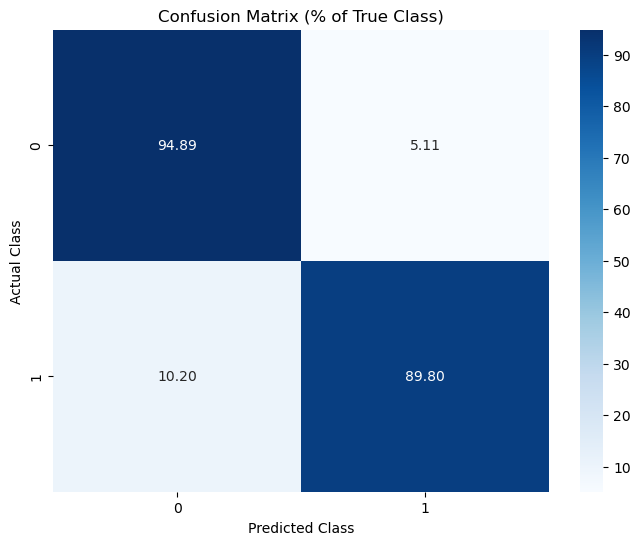

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

The accuracy matrix indicates that approximately 10% of actual positive cases were misclassified as negative (False Negatives), while around 5% of actual negative cases were misclassified as positive (False Positives). Without additional context, it is difficult to determine which type of error is more critical (from a business perspective).

# Sophisticated Strategy

In this context, two crucial factors affect model quality: how the features are encoded (the vectorized representation of the text, i.e. embeddings) and the model itself. I can use a simple feature encoder such as scikit-learn's TfidfVectorizer or a pre-trained model (e.g., from the SentenceTransformer API). In this section, I investigate both. 

## Advanced Embedding

In [36]:
model = SentenceTransformer('all-MiniLM-L12-v2', device = 'cpu') # This model seems to balance quality and computatinal complexity https://www.sbert.net/docs/sentence_transformer/pretrained_models.html 

In [37]:
X_train_st = model.encode(
    X_train.tolist(),
    max_seq_length = 192,
)

In [38]:
X_test_st = model.encode(
    X_test.tolist(),
    max_seq_length = 192,
)

In [39]:
model_st = LogisticRegression()
model_st.fit(X_train_st, y_train)

LogisticRegression()

In [40]:
y_pred_st = model_st.predict(X_test_st)
accuracy_st = np.round(accuracy_score(y_test, y_pred_st) * 100, 1)

In [41]:
accuracy_st

92.4

The out-of-sample performance is worse in comparison to the baseline model. Is overfitting a concern?

In [43]:
y_pred_is_st = model_st.predict(X_train_st)
accuracy_is_st = np.round(accuracy_score(y_train, y_pred_is_st) * 100, 1)

In [44]:
accuracy_is_st

91.5

Since IS and OOS fit are comparable, overfitting does not appear to be a concern. This suggests that simple vectorization may be sufficient for our case. Notice, however, that the gap in performance is small.

## Complex Model

In [47]:
model_rf = RandomForestClassifier(random_state = 42) # I did not engange in any hyperparameter tuning 
model_rf.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

In [48]:
y_pred_rf = model_rf.predict(X_test_vec)

In [49]:
accuracy_rf = np.round(accuracy_score(y_test, y_pred_rf) * 100, 1)
accuracy_rf

92.0

Once again, the performance decreases. Let us check the IS fit.

In [51]:
y_pred_is_rf = model_rf.predict(X_train_vec)
accuracy_is_rf = np.round(accuracy_score(y_train, y_pred_is_rf) * 100, 1)

In [52]:
accuracy_is_rf

100.0

This is a strong indication of overfitting. Since the model already overfits, there is no point in combining both complex strategies.

Due to the time constraint, I cannot spend more time on trial and error to beat the baseline model.

# Appendix - ANN Classification

In [58]:
X_train_vec.shape

(8456, 5228)

In [59]:
X_train_st.shape

(8456, 384)

In [60]:
input_dim = X_train_st.shape[1]

In [61]:
input_dim

384

In [62]:
model_ann = Sequential([
    Input(shape=(input_dim,)),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')  # Binary classification output
])

In [63]:
model_ann.compile(optimizer = Adam(learning_rate = 0.001), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])

In [64]:
early_stop = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights = True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.5, patience = 1, verbose = 1)

In [65]:
model_ann.fit(
    X_train_st, 
    y_train, 
    epochs = 50, 
    batch_size = 32, 
    validation_split = 0.2,
    callbacks = [early_stop, reduce_lr]
)

Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7862 - loss: 0.4702 - val_accuracy: 0.9178 - val_loss: 0.2129 - learning_rate: 0.0010
Epoch 2/50
209/212 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9014 - loss: 0.2352
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9014 - loss: 0.2352 - val_accuracy: 0.9173 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9118 - loss: 0.2098 - val_accuracy: 0.9285 - val_loss: 0.1876 - learning_rate: 5.0000e-04
Epoch 4/50
197/212 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9278 - loss: 0.1861
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9274 - loss: 0.1871 - val_accuracy: 0.9303 - val_loss: 0.1885 - learning_rate: 5.0000e-04
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9227 - loss: 0.1

In [66]:
y_pred_train_ann = model_ann.predict(X_train_st)

265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [67]:
binary_predictions = (y_pred_train_ann > 0.5).astype(int)

In [68]:
accuracy_ann_test = np.round(accuracy_score(y_train, binary_predictions) * 100, 1)
accuracy_ann_test

93.0

In [69]:
y_pred_ann = model_ann.predict(X_test_st)
binary_predictions_ann = (y_pred_ann > 0.5).astype(int)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [70]:
accuracy_ann = np.round(accuracy_score(y_test, binary_predictions_ann) * 100, 1)
accuracy_ann

91.7